## The linear elasticity problem

### (1) Data generating

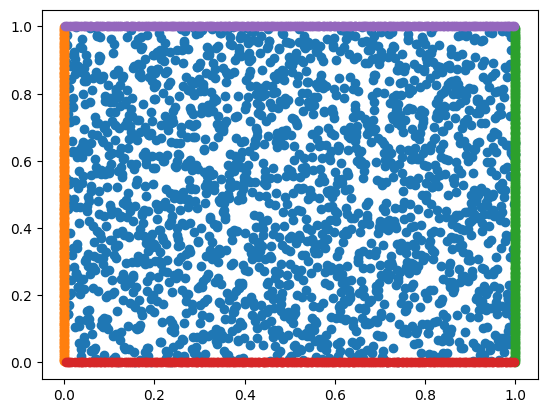

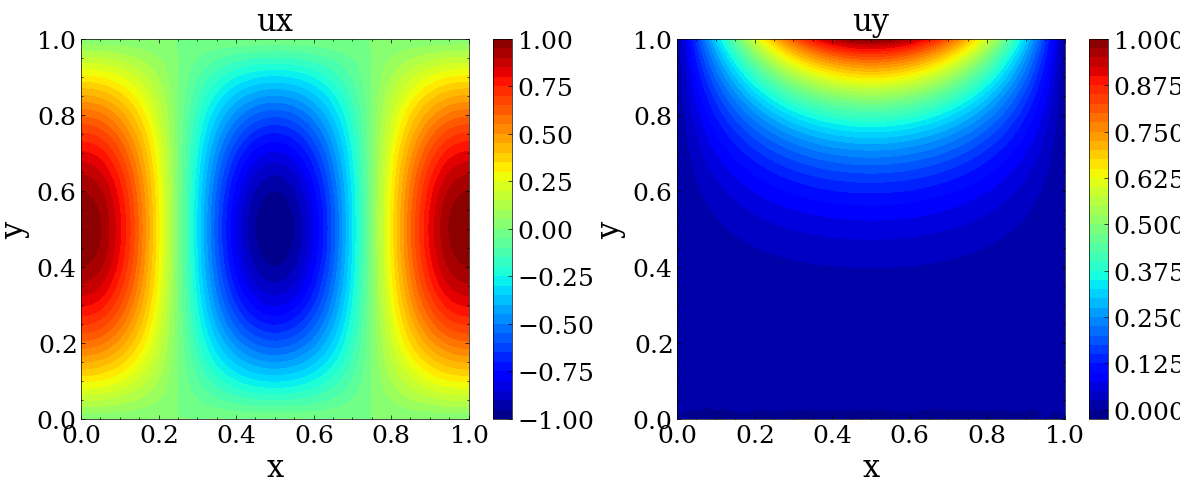

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 123
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'LinearElasticity_2d'
######################################
# Setups of the problem 
######################################
from Utils.GenPoints import Point2D
from Problems.Elasticity.LinearElasticity_2d import Problem
problem = Problem(lamda=1., mu=0.5, Q=4.)
pointGen = Point2D(x_lb=problem._lb, x_ub=problem._ub, dataType=dtype, random_seed=random_seed)
#
N_center, N_bd_each_edge = 2000, 200
xc_train, R_train = pointGen.weight_centers(n_center=N_center, R_max=1e-4, R_min=1e-4)
x_bd_train = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='hypercube')
x_test = pointGen.inner_point(num_sample_or_mesh=25, method='mesh')
#
x_lt = x_bd_train[0:N_bd_each_edge]
x_rt = x_bd_train[N_bd_each_edge:2*N_bd_each_edge]
x_bt = x_bd_train[2*N_bd_each_edge:3*N_bd_each_edge]
x_up = x_bd_train[3*N_bd_each_edge:]
#########################################
plt.figure()
plt.scatter(xc_train[...,0], xc_train[...,1])
plt.scatter(x_lt[:,0], x_lt[:,1])
plt.scatter(x_rt[:,0], x_rt[:,1])
plt.scatter(x_bt[:,0], x_bt[:,1])
plt.scatter(x_up[:,0], x_up[:,1])
plt.show()
#######################################
from Utils.PlotFigure import Plot
ux_test, uy_test = problem._ux_star(x_test), problem._uy_star(x_test)
sxx_test = problem._sxx_star(x_test)
syy_test = problem._syy_star(x_test)
sxy_test = problem._sxy_star(x_test)
Plot.show_2d_list(x_test, [ux_test, uy_test], ['ux', 'uy'], lb=0.)

### (2) Define the loss class

In [2]:
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=9, 
    dataType=dtype).get_testFun()

class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_us = solver.model_dict['us']
        ######################## 
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]
        self.v = phi.to(self.device)
        self.dv_dr = dphi_dr.to(self.device)

    def get_values(self, x_device):
        '''
        '''
        us = self.model_us(x_device)
        ux, uy = us[...,0:1], us[...,1:2]
        sxx, syy, sxy = us[...,2:3], us[...,3:4], us[...,4:5]
        
        return ux, uy, sxx, syy, sxy
        
    def Loss_pde(self, xc=None, R=None):
        '''

        '''
        # ##################################
        xc, R = pointGen.weight_centers(n_center=200, R_max=1e-4, R_min=1e-4)
        xc, R = xc.to(self.device), R.to(self.device)
        ################################## The collocation points
        nc = xc.shape[0]
        x = self.int_grid * R + xc
        x = Variable(x.reshape(-1, 2), requires_grad=True)
        ##########################################
        v = self.v.repeat((nc,1,1)).reshape(-1,1)
        dv = (self.dv_dr / R).reshape(-1, 2)
        ###########################
        fx, fy = problem.fun_f(x)
        ux, uy, sxx, syy, sxy = self.get_values(x)
        #
        dux = self.solver.grad(ux, [x])[0]
        duy = self.solver.grad(uy, [x])[0]
        #################
        res1 = sxx*dv[...,0:1] + sxy*dv[...,1:2] - fx * v
        res1 = torch.mean( res1.reshape(nc, self.n_grid), dim=-1, keepdim=True)
        res2 = sxy*dv[...,0:1] + syy*dv[...,1:2] - fy * v
        res2 = torch.mean(res2.reshape(nc, self.n_grid), dim=-1, keepdim=True)
        ##################
        Exx = dux[...,0:1]
        Eyy = duy[...,1:2]
        Exy = 0.5 * (dux[...,1:2] + duy[...,0:1])
        res3 = sxx - (2*problem.mu+problem.lamda)*Exx - problem.lamda * Eyy
        res4 = syy - (2*problem.mu+problem.lamda)*Eyy - problem.lamda * Exx
        res5 = sxy - 2*problem.mu*Exy
        #
        loss = (self.solver.getLoss(res1,  torch.zeros_like(res1))
                + self.solver.getLoss(res2,  torch.zeros_like(res2))
                + self.solver.getLoss(res3,  torch.zeros_like(res3))
                + self.solver.getLoss(res4,  torch.zeros_like(res4))
                + self.solver.getLoss(res5,  torch.zeros_like(res5))
               )
        return loss * 10.

    def Loss_bd(self):
        ''' '''
        loss = 0.
        ######### (left)
        _, uy, sxx, _, _ = self.get_values(x_lt.to(self.device))
        loss += self.solver.getLoss(uy , torch.zeros_like(uy))
        loss += self.solver.getLoss(sxx , torch.zeros_like(sxx))
        ######### (right)
        _, uy, sxx, _, _ = self.get_values(x_rt.to(self.device))
        loss += self.solver.getLoss(uy , torch.zeros_like(uy))
        loss += self.solver.getLoss(sxx , torch.zeros_like(sxx))
        ######### (bottom)
        ux, uy, _, _, _ = self.get_values(x_bt.to(self.device))
        loss += self.solver.getLoss(ux, torch.zeros_like(ux))
        loss += self.solver.getLoss(uy, torch.zeros_like(uy))
        ######### (up)
        xup = x_up.to(self.device)
        ux, _, _, syy, _ = self.get_values(xup)
        loss += self.solver.getLoss(ux, torch.zeros_like(ux))
        loss += self.solver.getLoss(
            (syy - (problem.lamda+2*problem.mu)*problem.Q*torch.sin(torch.pi * xup[...,0:1])), 
            torch.zeros_like(syy))
        return loss * 2.
        
    def Error(self):
        ''' '''
        ux = ux_test.to(self.device)
        uy = uy_test.to(self.device)
        sxx = sxx_test.to(self.device)
        syy = syy_test.to(self.device)
        sxy = sxy_test.to(self.device)
        #
        x = x_test.to(self.solver.device)
        ux_pred, uy_pred, sxx_pred, syy_pred, sxy_pred = self.get_values(x)
        #
        error = [self.solver.getError(ux_pred, ux), self.solver.getError(uy_pred, uy),
                self.solver.getError(sxx_pred, sxx), self.solver.getError(syy_pred, syy),
                self.solver.getError(sxy_pred, sxy)]
        
        return error

# #####################################
# # Define the model
# #####################################
from Solvers.ParticleWNN import ParticleWNN
#
solver = ParticleWNN.Solver(device, dtype=dtype)
us_model = solver.getModel(layers_list=[2, 40, 40, 40, 40, 40, 5], activation='Tanh', netType='FCNet')

### (3) Training and prediction

#### (3.1) Train the model

In [4]:
model_dict = {'us': us_model}
#
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR')
solver.train(LossClass, xc_train, R_train, batch_size_in=int(xc_train.shape[0]/100), epochs=1000, 
             **{'save_path':f'saved_models/'})

  1%|▌                                                       | 10/1000 [00:13<21:53,  1.33s/it]

Epoch:10 Time:13.6630, loss_in:71.777145, loss_bd:10.743144
    l2_err:[1.0003252029418945, 0.8577949404716492, 0.9995864033699036, 0.9702659845352173, 0.9986016154289246], 
    lr:[0.001]


  2%|█                                                       | 20/1000 [00:26<21:32,  1.32s/it]

Epoch:20 Time:26.8754, loss_in:72.351799, loss_bd:7.066233
    l2_err:[1.1741046905517578, 0.7728503942489624, 0.9980945587158203, 0.8917757868766785, 1.0367263555526733], 
    lr:[0.001]


  3%|█▋                                                      | 30/1000 [00:40<21:20,  1.32s/it]

Epoch:30 Time:40.0633, loss_in:65.359451, loss_bd:4.421668
    l2_err:[1.1817829608917236, 1.385420560836792, 0.9796783924102783, 0.621557891368866, 0.9815981388092041], 
    lr:[0.001]


  4%|██▏                                                     | 40/1000 [00:52<20:05,  1.26s/it]

Epoch:40 Time:52.8634, loss_in:37.291672, loss_bd:2.816032
    l2_err:[0.9164430499076843, 1.7690879106521606, 0.4920961856842041, 0.3515174388885498, 1.1140519380569458], 
    lr:[0.001]


  5%|██▊                                                     | 50/1000 [01:05<19:44,  1.25s/it]

Epoch:50 Time:65.3311, loss_in:7.503831, loss_bd:1.543761
    l2_err:[0.5306406021118164, 0.11150941252708435, 0.04576833173632622, 0.039244394749403, 0.49338528513908386], 
    lr:[0.001]


  6%|███▎                                                    | 60/1000 [01:17<19:39,  1.26s/it]

Epoch:60 Time:77.8593, loss_in:4.116116, loss_bd:0.738824
    l2_err:[0.21235214173793793, 0.07764730602502823, 0.03260388970375061, 0.025689026340842247, 0.22007139027118683], 
    lr:[0.001]


  7%|███▉                                                    | 70/1000 [01:29<17:05,  1.10s/it]

Epoch:70 Time:89.3932, loss_in:3.917146, loss_bd:0.864087
    l2_err:[0.0912690982222557, 0.060145530849695206, 0.020738694816827774, 0.015584242530167103, 0.10379741340875626], 
    lr:[0.001]


  8%|████▍                                                   | 80/1000 [01:40<16:28,  1.07s/it]

Epoch:80 Time:100.1407, loss_in:3.144370, loss_bd:0.920586
    l2_err:[0.04381073638796806, 0.030787905678153038, 0.016721628606319427, 0.012802371755242348, 0.06351929157972336], 
    lr:[0.001]


  9%|█████                                                   | 90/1000 [01:50<16:26,  1.08s/it]

Epoch:90 Time:110.9636, loss_in:2.458825, loss_bd:0.532897
    l2_err:[0.027223404496908188, 0.020792648196220398, 0.01569639891386032, 0.01480863243341446, 0.04217808321118355], 
    lr:[0.001]


 10%|█████▌                                                 | 100/1000 [02:01<16:11,  1.08s/it]

Epoch:100 Time:121.7557, loss_in:3.006957, loss_bd:0.740067
    l2_err:[0.01747637428343296, 0.02043927274644375, 0.013605311512947083, 0.01183644775301218, 0.03185136243700981], 
    lr:[0.001]


 11%|██████                                                 | 110/1000 [02:12<16:01,  1.08s/it]

Epoch:110 Time:132.5338, loss_in:2.037715, loss_bd:0.482418
    l2_err:[0.01692822016775608, 0.017087729647755623, 0.014934396371245384, 0.013852973468601704, 0.032181188464164734], 
    lr:[0.001]


 12%|██████▌                                                | 120/1000 [02:23<15:43,  1.07s/it]

Epoch:120 Time:143.2488, loss_in:2.493455, loss_bd:0.603895
    l2_err:[0.013265394605696201, 0.017061864957213402, 0.010697586461901665, 0.010404239408671856, 0.023870356380939484], 
    lr:[0.001]


 13%|███████▏                                               | 130/1000 [02:34<15:47,  1.09s/it]

Epoch:130 Time:154.0710, loss_in:2.381021, loss_bd:0.545752
    l2_err:[0.01238203514367342, 0.010609781369566917, 0.01196239423006773, 0.012677744962275028, 0.02113240398466587], 
    lr:[0.001]


 14%|███████▋                                               | 140/1000 [02:44<15:19,  1.07s/it]

Epoch:140 Time:164.7950, loss_in:2.261096, loss_bd:0.589030
    l2_err:[0.011638307012617588, 0.017919454723596573, 0.015520185232162476, 0.01740925945341587, 0.025314142927527428], 
    lr:[0.001]


 15%|████████▎                                              | 150/1000 [02:55<15:11,  1.07s/it]

Epoch:150 Time:175.5123, loss_in:1.785229, loss_bd:0.377597
    l2_err:[0.013600648380815983, 0.010519360192120075, 0.010575797408819199, 0.010518374852836132, 0.019341733306646347], 
    lr:[0.001]


 16%|████████▊                                              | 160/1000 [03:06<14:57,  1.07s/it]

Epoch:160 Time:186.2110, loss_in:1.782753, loss_bd:0.454747
    l2_err:[0.014426189474761486, 0.010269835591316223, 0.013795563951134682, 0.012144573964178562, 0.019331572577357292], 
    lr:[0.001]


 17%|█████████▎                                             | 170/1000 [03:16<14:46,  1.07s/it]

Epoch:170 Time:196.9034, loss_in:1.453598, loss_bd:0.315151
    l2_err:[0.019968654960393906, 0.009782458655536175, 0.010359233245253563, 0.01074283104389906, 0.021464822813868523], 
    lr:[0.001]


 18%|█████████▉                                             | 180/1000 [03:27<14:38,  1.07s/it]

Epoch:180 Time:207.6145, loss_in:1.636383, loss_bd:0.299122
    l2_err:[0.01145088393241167, 0.010504016652703285, 0.01116968784481287, 0.0099986232817173, 0.018576160073280334], 
    lr:[0.001]


 19%|██████████▍                                            | 190/1000 [03:38<14:28,  1.07s/it]

Epoch:190 Time:218.3512, loss_in:1.571628, loss_bd:0.273675
    l2_err:[0.00625622970983386, 0.011798392981290817, 0.011234249919652939, 0.011943772435188293, 0.015894968062639236], 
    lr:[0.001]


 20%|███████████                                            | 200/1000 [03:49<14:16,  1.07s/it]

Epoch:200 Time:229.0560, loss_in:1.861136, loss_bd:0.434535
    l2_err:[0.01282663457095623, 0.010813557542860508, 0.0073449984192848206, 0.008241614326834679, 0.017905183136463165], 
    lr:[0.0005]


 21%|███████████▌                                           | 210/1000 [03:59<14:10,  1.08s/it]

Epoch:210 Time:239.8034, loss_in:1.217178, loss_bd:0.322950
    l2_err:[0.009254194796085358, 0.006837201304733753, 0.007654341869056225, 0.00735672889277339, 0.0165291465818882], 
    lr:[0.0005]


 22%|████████████                                           | 220/1000 [04:10<13:55,  1.07s/it]

Epoch:220 Time:250.5176, loss_in:1.142959, loss_bd:0.280752
    l2_err:[0.006142735481262207, 0.010421628132462502, 0.005495716352015734, 0.007561449892818928, 0.015342292375862598], 
    lr:[0.0005]


 23%|████████████▋                                          | 230/1000 [04:21<13:45,  1.07s/it]

Epoch:230 Time:261.2304, loss_in:0.880233, loss_bd:0.173065
    l2_err:[0.004680870100855827, 0.013873213902115822, 0.004822250455617905, 0.006311624776571989, 0.014912894926965237], 
    lr:[0.0005]


 24%|█████████████▏                                         | 240/1000 [04:31<13:33,  1.07s/it]

Epoch:240 Time:271.9446, loss_in:1.110315, loss_bd:0.217176
    l2_err:[0.007477972190827131, 0.006072415504604578, 0.006294725928455591, 0.007071368861943483, 0.014577939175069332], 
    lr:[0.0005]


 25%|█████████████▊                                         | 250/1000 [04:42<13:21,  1.07s/it]

Epoch:250 Time:282.6432, loss_in:0.979149, loss_bd:0.249536
    l2_err:[0.006194030400365591, 0.009541238658130169, 0.006722529884427786, 0.0074965315870940685, 0.014226958155632019], 
    lr:[0.0005]


 26%|██████████████▎                                        | 260/1000 [04:53<13:11,  1.07s/it]

Epoch:260 Time:293.3483, loss_in:1.148090, loss_bd:0.191527
    l2_err:[0.006438101641833782, 0.00514225522056222, 0.007637684233486652, 0.007303965277969837, 0.015021231025457382], 
    lr:[0.0005]


 27%|██████████████▊                                        | 270/1000 [05:04<13:00,  1.07s/it]

Epoch:270 Time:304.0473, loss_in:0.927301, loss_bd:0.188775
    l2_err:[0.005837084259837866, 0.005752306431531906, 0.007655171677470207, 0.007396218832582235, 0.0148311210796237], 
    lr:[0.0005]


 28%|███████████████▍                                       | 280/1000 [05:14<12:48,  1.07s/it]

Epoch:280 Time:314.7232, loss_in:0.910939, loss_bd:0.227366
    l2_err:[0.0042226980440318584, 0.007172026205807924, 0.007287958636879921, 0.007462670095264912, 0.013906038366258144], 
    lr:[0.0005]


 29%|███████████████▉                                       | 290/1000 [05:25<12:39,  1.07s/it]

Epoch:290 Time:325.4213, loss_in:0.879683, loss_bd:0.186168
    l2_err:[0.004396531265228987, 0.012242226861417294, 0.007729248609393835, 0.00866987556219101, 0.013664654456079006], 
    lr:[0.0005]


 30%|████████████████▌                                      | 300/1000 [05:36<12:32,  1.08s/it]

Epoch:300 Time:336.1535, loss_in:1.124560, loss_bd:0.235701
    l2_err:[0.005064279306679964, 0.006536711007356644, 0.004000047687441111, 0.005070113576948643, 0.013157123699784279], 
    lr:[0.0005]


 31%|█████████████████                                      | 310/1000 [05:46<12:19,  1.07s/it]

Epoch:310 Time:346.8703, loss_in:0.831329, loss_bd:0.172317
    l2_err:[0.003927604295313358, 0.011604978702962399, 0.006436327006667852, 0.007694479078054428, 0.013802750036120415], 
    lr:[0.0005]


 32%|█████████████████▌                                     | 320/1000 [05:57<12:08,  1.07s/it]

Epoch:320 Time:357.5843, loss_in:0.868315, loss_bd:0.149630
    l2_err:[0.003916097339242697, 0.006189736071974039, 0.005582144483923912, 0.004899653606116772, 0.012993722222745419], 
    lr:[0.0005]


 33%|██████████████████▏                                    | 330/1000 [06:08<11:57,  1.07s/it]

Epoch:330 Time:368.3268, loss_in:0.802892, loss_bd:0.174119
    l2_err:[0.0046243080869317055, 0.008445368148386478, 0.005189754068851471, 0.005875612609088421, 0.01460062526166439], 
    lr:[0.0005]


 34%|██████████████████▋                                    | 340/1000 [06:19<11:47,  1.07s/it]

Epoch:340 Time:379.0426, loss_in:0.998575, loss_bd:0.184866
    l2_err:[0.005868114531040192, 0.011355624534189701, 0.006702860351651907, 0.008603082969784737, 0.013904718682169914], 
    lr:[0.0005]


 35%|███████████████████▎                                   | 350/1000 [06:29<11:36,  1.07s/it]

Epoch:350 Time:389.7651, loss_in:0.676278, loss_bd:0.158267
    l2_err:[0.004204746801406145, 0.010384422726929188, 0.003989663440734148, 0.004890809301286936, 0.012524744495749474], 
    lr:[0.0005]


 36%|███████████████████▊                                   | 360/1000 [06:40<11:26,  1.07s/it]

Epoch:360 Time:400.4915, loss_in:0.873277, loss_bd:0.206200
    l2_err:[0.0055772894993424416, 0.005701776593923569, 0.004771132953464985, 0.005182560998946428, 0.012723279185593128], 
    lr:[0.0005]


 37%|████████████████████▎                                  | 370/1000 [06:51<11:14,  1.07s/it]

Epoch:370 Time:411.2022, loss_in:0.931629, loss_bd:0.220188
    l2_err:[0.006652673706412315, 0.005406760144978762, 0.005810869392007589, 0.006538825109601021, 0.013349815271794796], 
    lr:[0.0005]


 38%|████████████████████▉                                  | 380/1000 [07:01<11:02,  1.07s/it]

Epoch:380 Time:421.9072, loss_in:0.975774, loss_bd:0.208582
    l2_err:[0.0039023743011057377, 0.005760259460657835, 0.005420940462499857, 0.005856068339198828, 0.012465550564229488], 
    lr:[0.0005]


 39%|█████████████████████▍                                 | 390/1000 [07:12<10:57,  1.08s/it]

Epoch:390 Time:432.7530, loss_in:0.725312, loss_bd:0.153385
    l2_err:[0.004402609076350927, 0.011208788491785526, 0.005258969031274319, 0.006422462873160839, 0.012653817422688007], 
    lr:[0.0005]


 40%|██████████████████████                                 | 400/1000 [07:23<10:44,  1.07s/it]

Epoch:400 Time:443.5235, loss_in:0.883330, loss_bd:0.212048
    l2_err:[0.003480594838038087, 0.008177130483090878, 0.0069074141792953014, 0.007449749857187271, 0.012779712677001953], 
    lr:[0.00025]


 41%|██████████████████████▌                                | 410/1000 [07:34<10:38,  1.08s/it]

Epoch:410 Time:454.2986, loss_in:0.519906, loss_bd:0.118552
    l2_err:[0.004395912401378155, 0.007438585162162781, 0.0037906484212726355, 0.005156324245035648, 0.011984298937022686], 
    lr:[0.00025]


 42%|███████████████████████                                | 420/1000 [07:45<10:23,  1.07s/it]

Epoch:420 Time:465.0354, loss_in:0.542694, loss_bd:0.098169
    l2_err:[0.004204984754323959, 0.009536453522741795, 0.0035212638322263956, 0.004783076234161854, 0.011925991624593735], 
    lr:[0.00025]


 43%|███████████████████████▋                               | 430/1000 [07:55<10:10,  1.07s/it]

Epoch:430 Time:475.7623, loss_in:0.572911, loss_bd:0.152771
    l2_err:[0.0035264105536043644, 0.006095892284065485, 0.0041156490333378315, 0.004488491918891668, 0.01252214889973402], 
    lr:[0.00025]


 44%|████████████████████████▏                              | 440/1000 [08:06<09:59,  1.07s/it]

Epoch:440 Time:486.4816, loss_in:0.358173, loss_bd:0.071883
    l2_err:[0.004820741713047028, 0.009126071818172932, 0.0033224511425942183, 0.004146060440689325, 0.011957488022744656], 
    lr:[0.00025]


 45%|████████████████████████▊                              | 450/1000 [08:17<09:48,  1.07s/it]

Epoch:450 Time:497.1704, loss_in:0.569741, loss_bd:0.090460
    l2_err:[0.002555676968768239, 0.011175683699548244, 0.004656150937080383, 0.004621230531483889, 0.011961239390075207], 
    lr:[0.00025]


 46%|█████████████████████████▎                             | 460/1000 [08:27<09:37,  1.07s/it]

Epoch:460 Time:507.8673, loss_in:0.515463, loss_bd:0.119786
    l2_err:[0.002733497181907296, 0.009240305982530117, 0.0047200629487633705, 0.005096668377518654, 0.012120984494686127], 
    lr:[0.00025]


 47%|█████████████████████████▊                             | 470/1000 [08:38<09:26,  1.07s/it]

Epoch:470 Time:518.5638, loss_in:0.630087, loss_bd:0.106216
    l2_err:[0.0029534385539591312, 0.006695539224892855, 0.003395881038159132, 0.004907775670289993, 0.011586014181375504], 
    lr:[0.00025]


 48%|██████████████████████████▍                            | 480/1000 [08:49<09:17,  1.07s/it]

Epoch:480 Time:529.2864, loss_in:0.552764, loss_bd:0.087889
    l2_err:[0.003998081665486097, 0.0071129933930933475, 0.0035568152088671923, 0.004073589574545622, 0.011466901749372482], 
    lr:[0.00025]


 49%|██████████████████████████▉                            | 490/1000 [09:00<09:07,  1.07s/it]

Epoch:490 Time:540.0079, loss_in:0.536604, loss_bd:0.132856
    l2_err:[0.0038187496829777956, 0.007728778291493654, 0.003375463653355837, 0.005004810635000467, 0.011625644750893116], 
    lr:[0.00025]


 50%|███████████████████████████▌                           | 500/1000 [09:10<08:57,  1.07s/it]

Epoch:500 Time:550.7490, loss_in:0.371413, loss_bd:0.067166
    l2_err:[0.003112347098067403, 0.007369013968855143, 0.0032135637011379004, 0.004080359824001789, 0.011681864969432354], 
    lr:[0.00025]


 51%|████████████████████████████                           | 510/1000 [09:21<08:45,  1.07s/it]

Epoch:510 Time:561.4861, loss_in:0.439726, loss_bd:0.102966
    l2_err:[0.0027914834208786488, 0.0062283361330628395, 0.0038994676433503628, 0.004486714489758015, 0.011193867772817612], 
    lr:[0.00025]


 52%|████████████████████████████▌                          | 520/1000 [09:32<08:35,  1.07s/it]

Epoch:520 Time:572.2284, loss_in:0.337450, loss_bd:0.064107
    l2_err:[0.0033166413195431232, 0.006064628716558218, 0.002653323346748948, 0.003968382719904184, 0.011536948382854462], 
    lr:[0.00025]


 53%|█████████████████████████████▏                         | 530/1000 [09:42<08:25,  1.08s/it]

Epoch:530 Time:582.9924, loss_in:0.412231, loss_bd:0.083116
    l2_err:[0.0025562031660228968, 0.005059679038822651, 0.0039483061991631985, 0.004552003927528858, 0.011160627007484436], 
    lr:[0.00025]


 54%|█████████████████████████████▋                         | 540/1000 [09:53<08:14,  1.07s/it]

Epoch:540 Time:593.7388, loss_in:0.431564, loss_bd:0.100224
    l2_err:[0.0041787344962358475, 0.006193953566253185, 0.004253539722412825, 0.005368776153773069, 0.01122125145047903], 
    lr:[0.00025]


 55%|██████████████████████████████▎                        | 550/1000 [10:04<08:04,  1.08s/it]

Epoch:550 Time:604.4974, loss_in:0.460804, loss_bd:0.116278
    l2_err:[0.004644601605832577, 0.007459685206413269, 0.0033888232428580523, 0.004725306294858456, 0.011304685845971107], 
    lr:[0.00025]


 56%|██████████████████████████████▊                        | 560/1000 [10:15<07:52,  1.07s/it]

Epoch:560 Time:615.2209, loss_in:0.358681, loss_bd:0.088792
    l2_err:[0.003663529409095645, 0.006857514381408691, 0.002514354418963194, 0.0036839477252215147, 0.010817830450832844], 
    lr:[0.00025]


 57%|███████████████████████████████▎                       | 570/1000 [10:25<07:41,  1.07s/it]

Epoch:570 Time:625.9444, loss_in:0.460439, loss_bd:0.102150
    l2_err:[0.0035213755909353495, 0.00662868982180953, 0.004210624378174543, 0.005528177600353956, 0.01137339137494564], 
    lr:[0.00025]


 58%|███████████████████████████████▉                       | 580/1000 [10:36<07:30,  1.07s/it]

Epoch:580 Time:636.6766, loss_in:0.488631, loss_bd:0.123903
    l2_err:[0.0027461950667202473, 0.007509317249059677, 0.004074035212397575, 0.004704590421169996, 0.011224881745874882], 
    lr:[0.00025]


 59%|████████████████████████████████▍                      | 590/1000 [10:47<07:21,  1.08s/it]

Epoch:590 Time:647.4213, loss_in:0.511835, loss_bd:0.117098
    l2_err:[0.003104499075561762, 0.010733326897025108, 0.004135045688599348, 0.0046883453615009785, 0.011112789623439312], 
    lr:[0.00025]


 60%|█████████████████████████████████                      | 600/1000 [10:58<07:09,  1.07s/it]

Epoch:600 Time:658.1667, loss_in:0.485741, loss_bd:0.082209
    l2_err:[0.004247488919645548, 0.0060690101236104965, 0.004018830135464668, 0.004857086576521397, 0.011552511714398861], 
    lr:[0.000125]


 61%|█████████████████████████████████▌                     | 610/1000 [11:08<06:58,  1.07s/it]

Epoch:610 Time:668.9184, loss_in:0.270219, loss_bd:0.057491
    l2_err:[0.0034317125100642443, 0.008187975734472275, 0.0027423957362771034, 0.0038466586265712976, 0.010890358127653599], 
    lr:[0.000125]


 62%|██████████████████████████████████                     | 620/1000 [11:19<06:47,  1.07s/it]

Epoch:620 Time:679.6593, loss_in:0.387527, loss_bd:0.079789
    l2_err:[0.003935649059712887, 0.008897616527974606, 0.0029274364933371544, 0.004392604809254408, 0.010957720689475536], 
    lr:[0.000125]


 63%|██████████████████████████████████▋                    | 630/1000 [11:30<06:35,  1.07s/it]

Epoch:630 Time:690.3485, loss_in:0.309626, loss_bd:0.052829
    l2_err:[0.003292541718110442, 0.007540232501924038, 0.002851651981472969, 0.0038893630262464285, 0.010818678885698318], 
    lr:[0.000125]


 64%|███████████████████████████████████▏                   | 640/1000 [11:41<06:27,  1.08s/it]

Epoch:640 Time:701.1272, loss_in:0.286587, loss_bd:0.066343
    l2_err:[0.0031015858985483646, 0.007150773890316486, 0.002703686011955142, 0.0038860889617353678, 0.010707857087254524], 
    lr:[0.000125]


 65%|███████████████████████████████████▊                   | 650/1000 [11:51<06:15,  1.07s/it]

Epoch:650 Time:711.8583, loss_in:0.353814, loss_bd:0.083871
    l2_err:[0.0026132697239518166, 0.0068439943715929985, 0.0033034372609108686, 0.003929206635802984, 0.010708913207054138], 
    lr:[0.000125]


 66%|████████████████████████████████████▎                  | 660/1000 [12:02<06:05,  1.08s/it]

Epoch:660 Time:722.6066, loss_in:0.262570, loss_bd:0.052943
    l2_err:[0.002825172385200858, 0.0066931238397955894, 0.0028875810094177723, 0.003828795161098242, 0.010779823176562786], 
    lr:[0.000125]


 67%|████████████████████████████████████▊                  | 670/1000 [12:13<05:53,  1.07s/it]

Epoch:670 Time:733.3288, loss_in:0.251244, loss_bd:0.058379
    l2_err:[0.0034174697939306498, 0.008770168758928776, 0.0024346376303583384, 0.003648102981969714, 0.010675229132175446], 
    lr:[0.000125]


 68%|█████████████████████████████████████▍                 | 680/1000 [12:24<05:43,  1.07s/it]

Epoch:680 Time:744.0819, loss_in:0.261211, loss_bd:0.045902
    l2_err:[0.0026909334119409323, 0.00841243751347065, 0.0027155124116688967, 0.0038388294633477926, 0.010851378552615643], 
    lr:[0.000125]


 69%|█████████████████████████████████████▉                 | 690/1000 [12:34<05:31,  1.07s/it]

Epoch:690 Time:754.7731, loss_in:0.351003, loss_bd:0.073719
    l2_err:[0.0037982272915542126, 0.008791693486273289, 0.0028875423595309258, 0.004285937640815973, 0.010467533022165298], 
    lr:[0.000125]


 70%|██████████████████████████████████████▌                | 700/1000 [12:45<05:20,  1.07s/it]

Epoch:700 Time:765.4493, loss_in:0.271207, loss_bd:0.043219
    l2_err:[0.0033014037180691957, 0.008419623598456383, 0.0026233550161123276, 0.0036834008060395718, 0.010695274919271469], 
    lr:[0.000125]


 71%|███████████████████████████████████████                | 710/1000 [12:56<05:12,  1.08s/it]

Epoch:710 Time:776.1838, loss_in:0.400575, loss_bd:0.085248
    l2_err:[0.0030850362963974476, 0.006064233370125294, 0.003626710269600153, 0.004436674527823925, 0.010490077547729015], 
    lr:[0.000125]


 72%|███████████████████████████████████████▌               | 720/1000 [13:06<05:01,  1.08s/it]

Epoch:720 Time:786.9376, loss_in:0.233566, loss_bd:0.045263
    l2_err:[0.0035127911251038313, 0.008333819918334484, 0.0026475132908672094, 0.003689992241561413, 0.010595318861305714], 
    lr:[0.000125]


 73%|████████████████████████████████████████▏              | 730/1000 [13:17<04:50,  1.08s/it]

Epoch:730 Time:797.6902, loss_in:0.357160, loss_bd:0.080388
    l2_err:[0.003744849469512701, 0.008656250312924385, 0.002647571498528123, 0.004263455513864756, 0.010593188926577568], 
    lr:[0.000125]


 74%|████████████████████████████████████████▋              | 740/1000 [13:28<04:39,  1.08s/it]

Epoch:740 Time:808.4630, loss_in:0.256106, loss_bd:0.046942
    l2_err:[0.002998901065438986, 0.007047714199870825, 0.0026489433366805315, 0.0037815559189766645, 0.010266462340950966], 
    lr:[0.000125]


 75%|█████████████████████████████████████████▎             | 750/1000 [13:39<04:29,  1.08s/it]

Epoch:750 Time:819.2508, loss_in:0.275454, loss_bd:0.056830
    l2_err:[0.0031749794725328684, 0.008763113990426064, 0.003353859530761838, 0.004608325194567442, 0.010678960010409355], 
    lr:[0.000125]


 76%|█████████████████████████████████████████▊             | 760/1000 [13:49<04:17,  1.07s/it]

Epoch:760 Time:829.9907, loss_in:0.413628, loss_bd:0.097955
    l2_err:[0.003243075916543603, 0.009724456816911697, 0.002746926387771964, 0.004051686264574528, 0.010432152077555656], 
    lr:[0.000125]


 77%|██████████████████████████████████████████▎            | 770/1000 [14:00<04:07,  1.07s/it]

Epoch:770 Time:840.7206, loss_in:0.336589, loss_bd:0.073969
    l2_err:[0.0034542004577815533, 0.007280486635863781, 0.0026839410420507193, 0.0038923141546547413, 0.010354642756283283], 
    lr:[0.000125]


 78%|██████████████████████████████████████████▉            | 780/1000 [14:11<03:55,  1.07s/it]

Epoch:780 Time:851.4480, loss_in:0.225304, loss_bd:0.051387
    l2_err:[0.003118559718132019, 0.006662182509899139, 0.0027315595652908087, 0.003759934799745679, 0.010183898732066154], 
    lr:[0.000125]


 79%|███████████████████████████████████████████▍           | 790/1000 [14:22<03:44,  1.07s/it]

Epoch:790 Time:862.1679, loss_in:0.282267, loss_bd:0.065870
    l2_err:[0.0036480724811553955, 0.008529754355549812, 0.0033450990449637175, 0.004316904582083225, 0.010121045634150505], 
    lr:[0.000125]


 80%|████████████████████████████████████████████           | 800/1000 [14:32<03:34,  1.07s/it]

Epoch:800 Time:872.8992, loss_in:0.356798, loss_bd:0.084894
    l2_err:[0.00348559208214283, 0.0073178415186703205, 0.002540231216698885, 0.003914674744009972, 0.010126383043825626], 
    lr:[6.25e-05]


 81%|████████████████████████████████████████████▌          | 810/1000 [14:43<03:23,  1.07s/it]

Epoch:810 Time:883.6267, loss_in:0.235598, loss_bd:0.039721
    l2_err:[0.0029760871548205614, 0.007569591514766216, 0.0025526992976665497, 0.0037067201919853687, 0.010227578692138195], 
    lr:[6.25e-05]


 82%|█████████████████████████████████████████████          | 820/1000 [14:54<03:14,  1.08s/it]

Epoch:820 Time:894.4159, loss_in:0.226587, loss_bd:0.039761
    l2_err:[0.0030610437970608473, 0.00831041019409895, 0.002710761269554496, 0.00397057319059968, 0.010300721973180771], 
    lr:[6.25e-05]


 83%|█████████████████████████████████████████████▋         | 830/1000 [15:05<03:02,  1.08s/it]

Epoch:830 Time:905.1852, loss_in:0.217720, loss_bd:0.039580
    l2_err:[0.0029368922114372253, 0.0083785280585289, 0.00273510767146945, 0.003845436265692115, 0.010076731443405151], 
    lr:[6.25e-05]


 84%|██████████████████████████████████████████████▏        | 840/1000 [15:15<02:52,  1.08s/it]

Epoch:840 Time:915.9609, loss_in:0.228061, loss_bd:0.046035
    l2_err:[0.0030623467173427343, 0.00776034127920866, 0.0026859126519411802, 0.0037598193157464266, 0.010144193656742573], 
    lr:[6.25e-05]


 85%|██████████████████████████████████████████████▊        | 850/1000 [15:26<02:40,  1.07s/it]

Epoch:850 Time:926.6906, loss_in:0.225403, loss_bd:0.038295
    l2_err:[0.0033314756583422422, 0.008761502802371979, 0.0027878768742084503, 0.0037364326417446136, 0.01024492084980011], 
    lr:[6.25e-05]


 86%|███████████████████████████████████████████████▎       | 860/1000 [15:37<02:30,  1.08s/it]

Epoch:860 Time:937.4372, loss_in:0.225745, loss_bd:0.041398
    l2_err:[0.0029634106904268265, 0.007445411290973425, 0.0024416514206677675, 0.003564296755939722, 0.010357576422393322], 
    lr:[6.25e-05]


 87%|███████████████████████████████████████████████▊       | 870/1000 [15:48<02:19,  1.07s/it]

Epoch:870 Time:948.1620, loss_in:0.263398, loss_bd:0.040881
    l2_err:[0.003237122669816017, 0.008031998760998249, 0.002736663678660989, 0.003762547392398119, 0.010335958562791348], 
    lr:[6.25e-05]


 88%|████████████████████████████████████████████████▍      | 880/1000 [15:58<02:09,  1.08s/it]

Epoch:880 Time:958.9234, loss_in:0.213641, loss_bd:0.041338
    l2_err:[0.0036153390537947416, 0.00838725920766592, 0.002567186951637268, 0.0036059634294360876, 0.010217215865850449], 
    lr:[6.25e-05]


 89%|████████████████████████████████████████████████▉      | 890/1000 [16:09<01:58,  1.07s/it]

Epoch:890 Time:969.6639, loss_in:0.228970, loss_bd:0.043446
    l2_err:[0.00325390906073153, 0.00826236978173256, 0.002656680764630437, 0.003646415425464511, 0.010058912448585033], 
    lr:[6.25e-05]


 90%|█████████████████████████████████████████████████▌     | 900/1000 [16:20<01:47,  1.07s/it]

Epoch:900 Time:980.3965, loss_in:0.224283, loss_bd:0.046535
    l2_err:[0.0026457933709025383, 0.00786314345896244, 0.0025774554815143347, 0.0036578194703906775, 0.010023586452007294], 
    lr:[6.25e-05]


 91%|██████████████████████████████████████████████████     | 910/1000 [16:31<01:36,  1.08s/it]

Epoch:910 Time:991.1599, loss_in:0.229143, loss_bd:0.035130
    l2_err:[0.0029694014228880405, 0.00858786329627037, 0.0025234450586140156, 0.0035626417957246304, 0.009954912588000298], 
    lr:[6.25e-05]


 92%|██████████████████████████████████████████████████▌    | 920/1000 [16:41<01:25,  1.07s/it]

Epoch:920 Time:1001.9109, loss_in:0.231284, loss_bd:0.046644
    l2_err:[0.0030816306825727224, 0.009444654919207096, 0.002505342708900571, 0.0037057932931929827, 0.010045678354799747], 
    lr:[6.25e-05]


 93%|███████████████████████████████████████████████████▏   | 930/1000 [16:52<01:15,  1.08s/it]

Epoch:930 Time:1012.6915, loss_in:0.257736, loss_bd:0.043315
    l2_err:[0.0031820659060031176, 0.009009335190057755, 0.002488433150574565, 0.0036316202022135258, 0.009869623929262161], 
    lr:[6.25e-05]


 94%|███████████████████████████████████████████████████▋   | 940/1000 [17:03<01:04,  1.08s/it]

Epoch:940 Time:1023.4859, loss_in:0.328001, loss_bd:0.036979
    l2_err:[0.002996329450979829, 0.008495406247675419, 0.002697032643482089, 0.003561761463060975, 0.009820203296840191], 
    lr:[6.25e-05]


 95%|████████████████████████████████████████████████████▎  | 950/1000 [17:14<00:53,  1.07s/it]

Epoch:950 Time:1034.2392, loss_in:0.219786, loss_bd:0.038164
    l2_err:[0.002739719580858946, 0.008898256346583366, 0.0025476012378931046, 0.003542061662301421, 0.009964985772967339], 
    lr:[6.25e-05]


 96%|████████████████████████████████████████████████████▊  | 960/1000 [17:24<00:42,  1.07s/it]

Epoch:960 Time:1044.9926, loss_in:0.259431, loss_bd:0.043142
    l2_err:[0.003305962076410651, 0.008843404240906239, 0.002622836735099554, 0.004080041777342558, 0.009852875024080276], 
    lr:[6.25e-05]


 97%|█████████████████████████████████████████████████████▎ | 970/1000 [17:35<00:32,  1.08s/it]

Epoch:970 Time:1055.7773, loss_in:0.211865, loss_bd:0.042776
    l2_err:[0.0025354591198265553, 0.00704722385853529, 0.0024997470900416374, 0.0037060489412397146, 0.009826087392866611], 
    lr:[6.25e-05]


 98%|█████████████████████████████████████████████████████▉ | 980/1000 [17:46<00:21,  1.08s/it]

Epoch:980 Time:1066.5371, loss_in:0.210123, loss_bd:0.035784
    l2_err:[0.0026509170420467854, 0.008197074756026268, 0.0024626378435641527, 0.0038130106404423714, 0.009869720786809921], 
    lr:[6.25e-05]


 99%|██████████████████████████████████████████████████████▍| 990/1000 [17:57<00:10,  1.08s/it]

Epoch:990 Time:1077.3131, loss_in:0.259974, loss_bd:0.044265
    l2_err:[0.00343277957290411, 0.007244153413921595, 0.0025024465285241604, 0.003796750446781516, 0.009820356965065002], 
    lr:[6.25e-05]


100%|██████████████████████████████████████████████████████| 1000/1000 [18:08<00:00,  1.09s/it]

Epoch:1000 Time:1088.0943, loss_in:0.212167, loss_bd:0.036128
    l2_err:[0.0031132397707551718, 0.008112117648124695, 0.0028499530162662268, 0.0036199449095875025, 0.009685719385743141], 
    lr:[3.125e-05]
The total training time is 1088.1575


#### (3.2) Make prediction

The l2 error: ux tensor([0.0036]) uy tensor([0.0086]) sxx tensor([0.0025]) syy tensor([0.0036]) sxy tensor([0.0097])


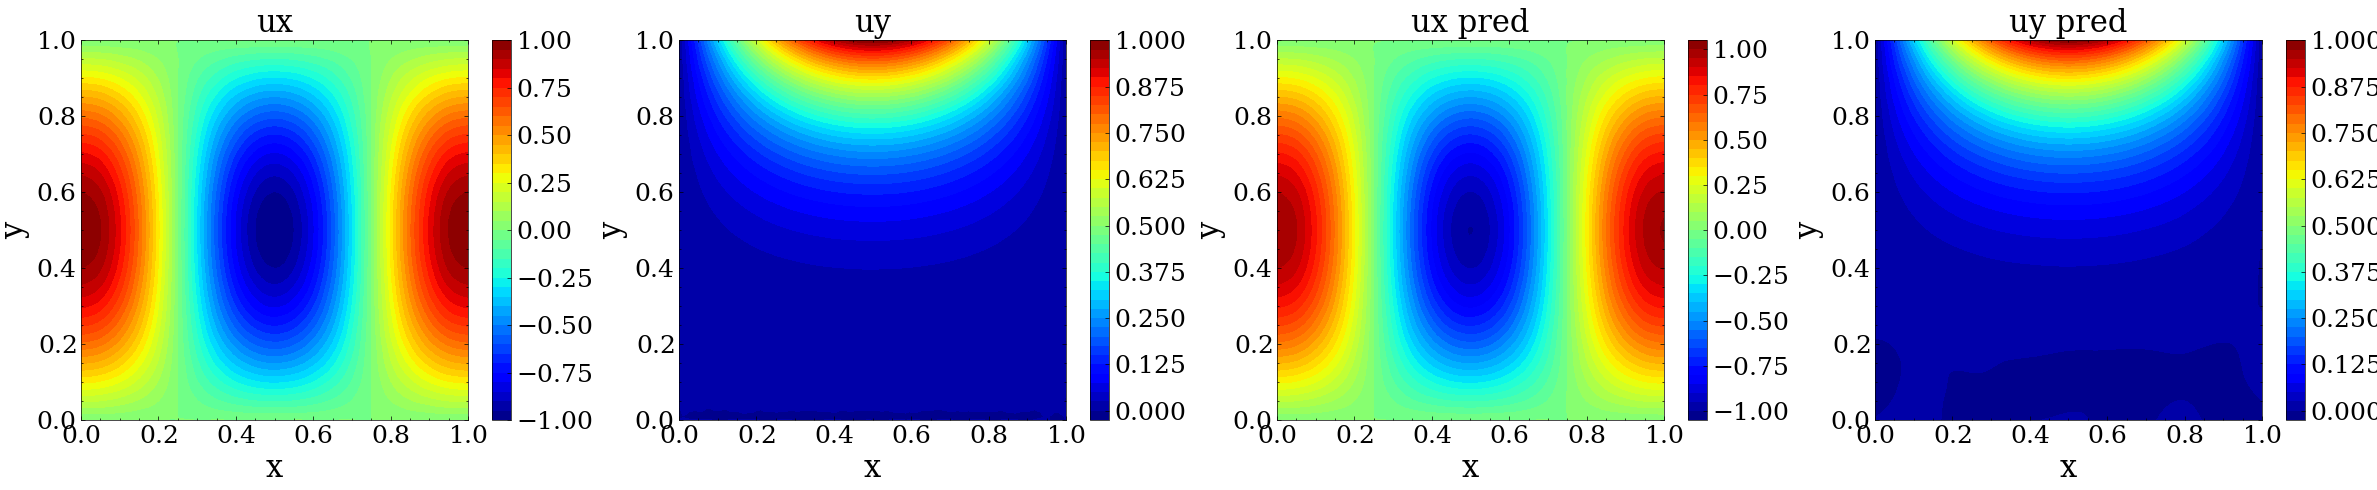

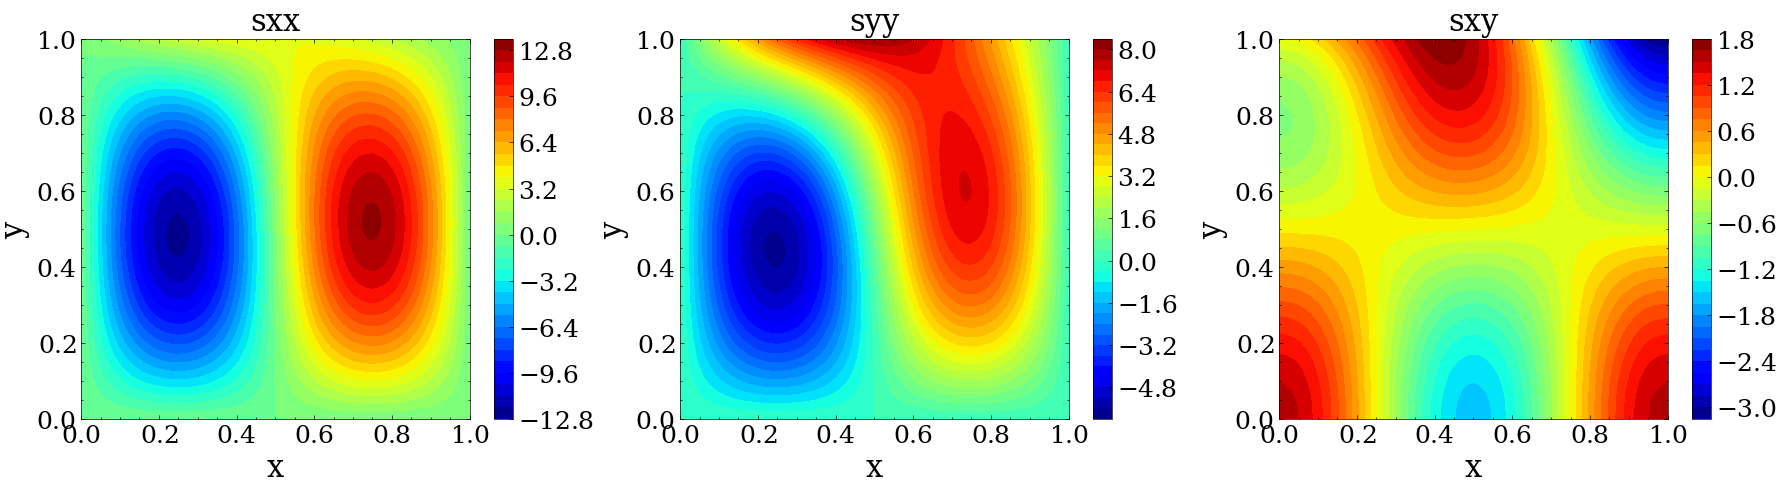

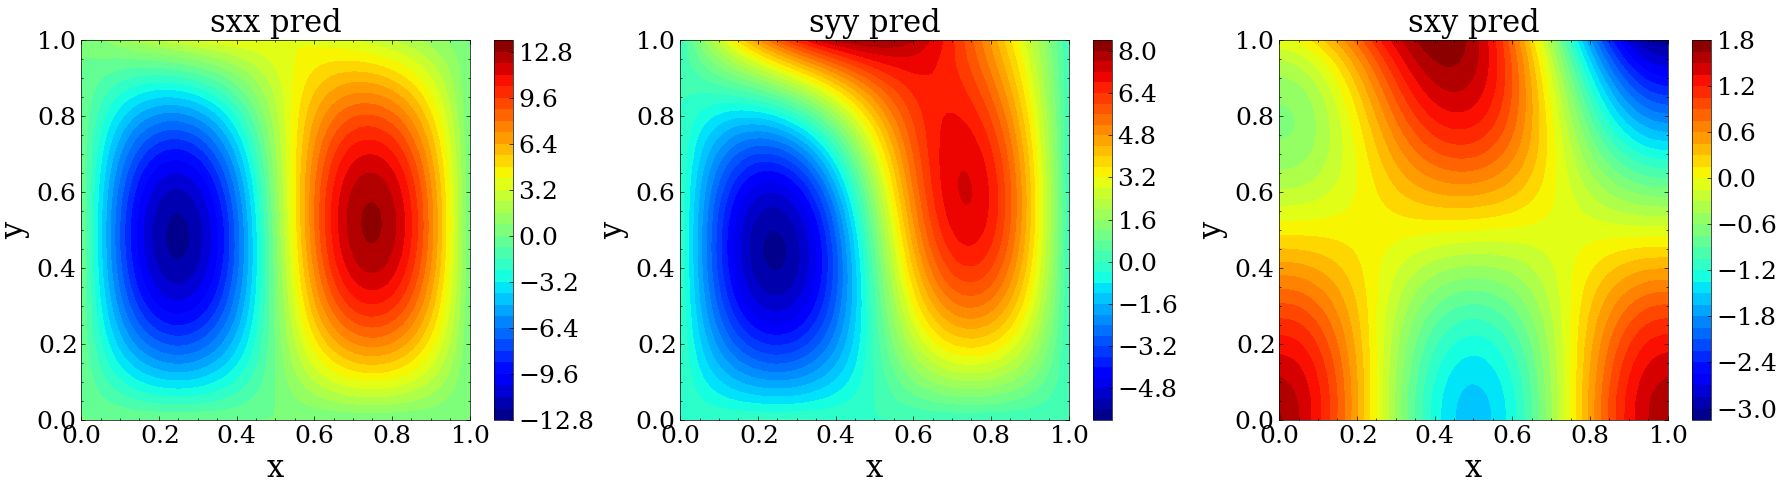

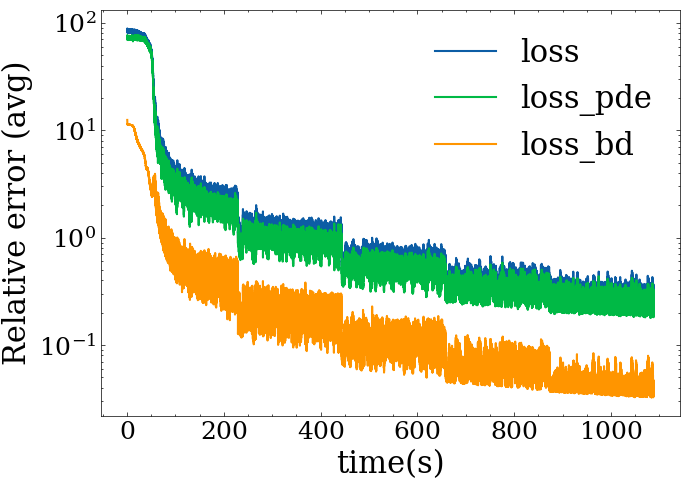

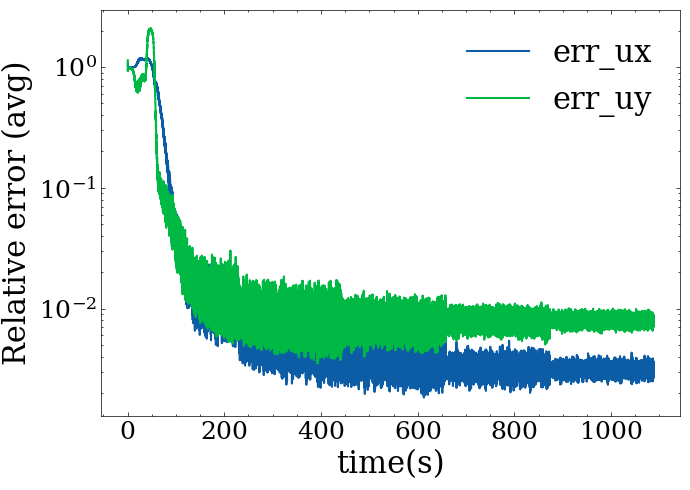

In [3]:
from Utils.PlotFigure import Plot
from Solvers.ParticleWNN import ParticleWNN
from Utils.Losses import * 
myerror = MyLoss().lp_rel
###############################
# load trained model
###############################
solver = ParticleWNN.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/', name='model_particlewnn_final')

###############################
# make prediction
###############################
with torch.no_grad():
    us = model_trained['us'](x_test.to(device))
    ux_pred = us[...,0:1].detach().cpu()
    uy_pred = us[...,1:2].detach().cpu()
    sxx_pred = us[...,2:3].detach().cpu()
    syy_pred = us[...,3:4].detach().cpu()
    sxy_pred = us[...,4:5].detach().cpu()
#
print('The l2 error: ux', myerror(ux_pred, ux_test), 'uy', myerror(uy_pred, uy_test), 
      'sxx', myerror(sxx_pred, sxx_test), 'syy', myerror(syy_pred, syy_test), 'sxy', myerror(sxy_pred, sxy_test))
###############################
# show the result
###############################
# show the solution
Plot.show_2d_list(x_test, [ux_test, uy_test, ux_pred, uy_pred], ['ux', 'uy', 'ux pred', 'uy pred'])
Plot.show_2d_list(x_test, [sxx_test, syy_test, sxy_test], ['sxx', 'syy', 'sxy'])
Plot.show_2d_list(x_test, [sxx_pred, syy_pred, sxy_pred], ['sxx pred', 'syy pred', 'sxy pred'])
# show the loss
loss_saved = solver.loadLoss(path=f'saved_models/', name='loss_particlewnn')
Plot.show_error([loss_saved['time']]*3, 
                [loss_saved['loss'], loss_saved['loss_pde'], loss_saved['loss_bd']],
                ['loss', 'loss_pde', 'loss_bd'])
# show the error
Plot.show_error([loss_saved['time']]*2, [loss_saved['error'][:,0], loss_saved['error'][:,1]], ['err_ux', 'err_uy'])